In [6]:
import os
import json
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from sklearn.model_selection import train_test_split

In [7]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

In [8]:
# Import OS libraries
import os
import itertools

# Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# from googleapiclient.discovery import build
# from google.oauth2.credentials import Credentials
# from googleapiclient.http import MediaFileUpload

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

GPU is not available


In [9]:
# Diretório onde estão armazenadas as imagens sem ser separadas por pastas
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [10]:
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [11]:
# Caminho para o arquivo de IDs das imagens com fundo dark
ids_dark = r'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\dark_images_ids.txt'

# Carregar IDs do grupo de treinamento de um arquivo de texto
with open(ids_dark, 'r') as file:
    ids = [line.strip() for line in file.readlines()]

In [12]:
print(f"Número de IDs carregados: {len(ids)}")
print(f"Primeiros 5 IDs: {ids[:5]}")

Número de IDs carregados: 9649
Primeiros 5 IDs: ['10000', '10001', '10002', '10003', '10004']


In [13]:
# Dividir os IDs em treinamento e validação (por exemplo, 80% para treinamento e 20% para validação)
split_index = int(len(ids) * 0.8)
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [14]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue

        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue

        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue

        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [15]:
print(f"Número de imagens no conjunto de treinamento: {len(train_data)}")
print(f"Número de imagens no conjunto de validação: {len(val_data)}")

Número de imagens no conjunto de treinamento: 7718
Número de imagens no conjunto de validação: 1930


In [16]:
# Separar caminhos de imagem e rótulos para treinamento e validação
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

In [17]:
# Converter os rótulos em formato adequado (numérico), se necessário
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)


In [18]:
# Converter os rótulos em one-hot encoded
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [19]:
# Obter o número de classes a partir do one hot encoder
num_classes = len(one_hot_encoder.categories_[0])
num_classes

5

In [20]:
# Função para gerar batches de dados
def data_generator(image_paths, labels_one_hot, batch_size=8, target_size=(112, 112)):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels_one_hot[start:end]
            batch_images = []
            for path in batch_paths:
                image = load_image(path, target_size)
                if image is not None:
                    batch_images.append(image)
            yield np.array(batch_images), np.array(batch_labels)

In [21]:
# Criar geradores de dados para treinamento e validação
train_generator = data_generator(train_images, train_labels_one_hot, batch_size=8, target_size=(112, 112))
val_generator = data_generator(val_images, val_labels_one_hot, batch_size=8, target_size=(112, 112))

In [22]:
# Criar o modelo da CNN
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Corrigido para usar `num_classes`
])

In [23]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 8,  # Número total de batches
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_images) // 8   # Número total de batches de validação
)

Epoch 1/10
964/964 [==============================] - 1747s 2s/step - loss: 1.5317 - accuracy: 0.2907 - val_loss: 1.6045 - val_accuracy: 0.1981
Epoch 2/10
964/964 [==============================] - 2201s 2s/step - loss: 1.4296 - accuracy: 0.3361 - val_loss: 1.6343 - val_accuracy: 0.2822
Epoch 3/10
964/964 [==============================] - 2750s 3s/step - loss: 1.3718 - accuracy: 0.3695 - val_loss: 1.7043 - val_accuracy: 0.2946
Epoch 4/10
964/964 [==============================] - 208157s 216s/step - loss: 1.3246 - accuracy: 0.4170 - val_loss: 1.6024 - val_accuracy: 0.2863
Epoch 5/10
964/964 [==============================] - 2329s 2s/step - loss: 1.2927 - accuracy: 0.4311 - val_loss: 1.5729 - val_accuracy: 0.3081
Epoch 6/10
964/964 [==============================] - 1915s 2s/step - loss: 1.2580 - accuracy: 0.4445 - val_loss: 1.5849 - val_accuracy: 0.3470
Epoch 7/10
964/964 [==============================] - 1851s 2s/step - loss: 1.2324 - accuracy: 0.4616 - val_loss: 1.6814 - val_accur

In [29]:
model.save('trained_model.dark')

INFO:tensorflow:Assets written to: trained_model.dark\assets


INFO:tensorflow:Assets written to: trained_model.dark\assets


In [24]:
import tensorflow as tf

# Carregar o modelo salvo
model = tf.keras.models.load_model('trained_model.dark')
print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!


In [25]:
# Função para gerar batches de dados
def data_generator(image_paths, labels_one_hot, batch_size=8, target_size=(112, 112)):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels_one_hot[start:end]
            batch_images = []
            for path in batch_paths:
                image = load_image(path, target_size)
                if image is not None:
                    batch_images.append(image)
            yield np.array(batch_images), np.array(batch_labels)

In [26]:
# Criar geradores de dados para validação
val_generator = data_generator(val_images, val_labels_one_hot, batch_size=8, target_size=(112, 112))

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Obter todas as imagens e rótulos do gerador de validação
val_images_all = []
val_labels_all = []
for batch_images, batch_labels in val_generator:
    val_images_all.extend(batch_images)
    val_labels_all.extend(batch_labels)
    if len(val_images_all) >= len(val_images):  
        break

In [28]:
# Converter para numpy arrays
val_images_all = np.array(val_images_all)
val_labels_all = np.array(val_labels_all)

In [29]:
# Salvar arrays para uso futuro
np.save('val_images_all.npy', val_images_all)
np.save('val_labels_all.npy', val_labels_all)

In [30]:
# Obter previsões do modelo
val_predictions = model.predict(val_images_all, batch_size=8)

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_all, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
# Converter os valores de one_hot_encoder.categories_[0] para strings
target_names = [str(int(label)) for label in one_hot_encoder.categories_[0]]
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

242/242 [==============================] - 5s 18ms/step
Matriz de Confusão:
[[ 21 227  40 178   2]
 [  7 294   1  15   2]
 [ 12  31 159 147  11]
 [  6  43  61 252   3]
 [  8  76  88 105 141]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.39      0.04      0.08       468
           1       0.44      0.92      0.59       319
           2       0.46      0.44      0.45       360
           3       0.36      0.69      0.47       365
           4       0.89      0.34      0.49       418

    accuracy                           0.45      1930
   macro avg       0.51      0.49      0.42      1930
weighted avg       0.51      0.45      0.40      1930



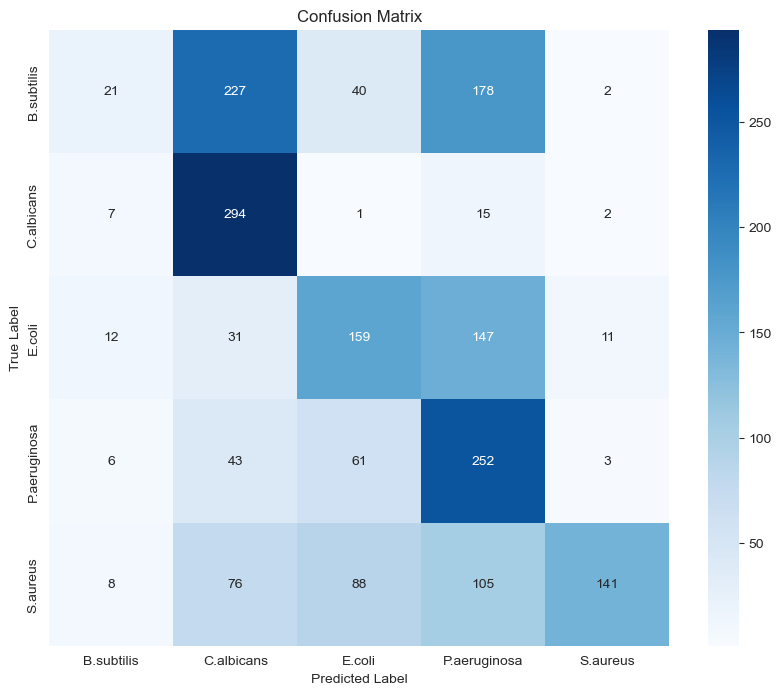

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [32]:
# Salvar a matriz de confusão e o relatório de classificação
np.save('confusion_matrix.npy', conf_matrix)